In [8]:
from blackjacksim.entities import *
from blackjacksim.strategies import basic
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# import jtplot module in notebook
from jupyterthemes import jtplot
import multiprocessing as mp
from time import time

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='poster', fscale=1.4, spines=False, gridlines='--')

startingPool = 3000

def one_round(procnum, send_end):
    data = []
    house = Blackjack32()
    wallet = PlayerWallet(1,startingPool)
    d = Dealer()
    p = Player(basic, wallet, house)
    s = Shoe(8,.25)
    for t in range(100):
        s = p.deal(s)
        s = d.deal(s)
        s = p.play(s, d.up_card)
        s = d.play(s, p.hands)
        for h in p.hands:
            wallet.take_payout(house.payout(h, d.hand))
        rw, rp = wallet.finish_round()
        data.append({'Round':t,'Pool':wallet.wager_pool, 'Wager':rw, 'Payout':rp, 'Shoe Penetration':s._penetration_state})
    send_end.send(data)


df_list = []
for n in range(1):
    pipe_list = []
    start = time()
    processes = []
    for i in tnrange(100):
        recv_end, send_end = mp.Pipe(False)
        p = mp.Process(target=one_round, args=(i, send_end))
        processes.append(p)
        pipe_list.append(recv_end)
        p.start()

    for process in processes:
        process.join()
    df_list.extend([x.recv() for x in pipe_list])
data = [i for s in df_list for i in s]


In [9]:
print(len(data))

10000


In [12]:
from blackjacksim.entities import *
from blackjacksim.strategies import basic
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from multiprocessing import Process, Manager, Pool

    
def game(data, house, wallet, dealer, player, shoe, num_rounds=1):
    for t in range(num_rounds):
        try:
            s_pen = shoe.penetration
            s_state = shoe.state
            shoe = player.deal(shoe)
            shoe = dealer.deal(shoe)
            shoe = player.play(shoe, dealer.up_card)
            shoe = dealer.play(shoe, player.hands)
            for h in player.hands:
                wallet.take_payout(house.payout(h, dealer.hand))
            rw, rp = wallet.finish_round()
            house.finish_round()
            data.append({'Round':t,
                         'Pool':wallet.wager_pool, 
                         'Wager':rw, 
                         'Payout':rp, 
                         'Shoe Penetration':s_pen, 
                         'State':str(s_state), 
                         'Advantage':rp-rw,
                        'House':str(house)})
            shoe = dealer.inspect_shoe(shoe)
        except:
            raise Exception(player.hands)
                
    return data

startingPool = 100
#data = []
for house in [Blackjack32(), Blackjack65(), Blackjack32NoSplit(), Blackjack65NoSplit()]:
    for i in tnrange(1000):
        wallet = PlayerWallet(1,startingPool)
        dealer = Dealer()
        player = Player(basic, wallet, house)
        shoe = Shoe(8,.75, house)
        data = game(data, house, wallet, dealer, player, shoe, num_rounds=100)
            
print(len(data))
df = pd.DataFrame(list(data))


2000000


                   Advantage                    
                        mean       std       var
House                                           
Blackjack32        -0.002398  1.183659  1.401048
Blackjack32NoSplit -0.006055  1.184483  1.403001
Blackjack65        -0.019391  1.169290  1.367238
Blackjack65NoSplit -0.016022  1.169789  1.368406


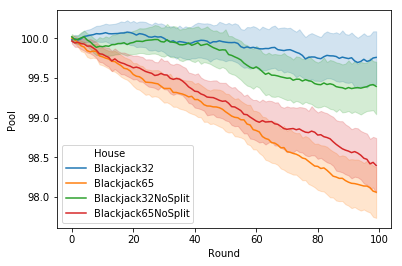

In [14]:
print(df.groupby('House').agg({'Advantage':['mean','std','var']}))
sns.lineplot(x='Round', y='Pool', hue='House', data=df)
plt.show()